In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from causal_rl.algo.imitation.imitate_single_step import *
from causal_rl.algo.imitation.data import ExpertDataset
from causal_rl.algo.imitation.gan import *
from causal_gym import HighwaySingleStepPCH

In [2]:
pch = HighwaySingleStepPCH()
nodes, base, conf = pch.env.get_graph
G = parse_graph(nodes, base, conf)

In [3]:
print(G.de)
print(G.be)
print(G.v)

[('X', 'Y'), ('Z', 'X'), ('Z', 'Y'), ('L', 'X'), ('L', 'W')]
[('W', 'Y')]
['L', 'W', 'Z', 'X', 'Y']


In [4]:
G_x_bar = G.subgraph(G.set_v, set(), {'X'})
d_separated(G_x_bar, {'X'}, {'Y'}, {'Z'})

True

In [5]:
G_bar_x = G.subgraph(G.set_v, {'X'}, set())
identify({'X'}, {'Y'}, G_bar_x).__str__()

'sum{Z}[[P(Z,L) / P(L)][P(Y,X,Z,L) / P(L,X,Z)]]'

In [6]:
observed, _ = pch.env.observed_unobserved_vars
Pa_pi = conditioning_set(G, 'X', 'Y', observed)
Pa_pi

{'W', 'Z'}

In [7]:
find_pi_backdoor(G, 'X', 'Y', Pa_pi)

{'Z'}

In [10]:
ACTIONS = {'SLOWER': 0, 'IDLE': 1, 'FASTER': 2}
def behavioral_policy(u, x, z, w, l):
    return ACTIONS['SLOWER'] if u else ACTIONS['FASTER']

In [31]:
records = collect_expert_trajectories(pch, num_episodes=128)
records[0]

{'episode': 0,
 'step': 0,
 'obs': {'x': 20.8544411731307, 'z': 20.717955445870587, 'w': 0},
 'action': 0,
 'reward': True,
 'terminated': True,
 'truncated': True,
 'info': {'u': 0, 'l': 1, 'y': True}}

In [32]:
dataset_ci = ExpertDataset(records, cond_vars=['z'], action_var='action')
loader_ci = torch.utils.data.DataLoader(dataset_ci, batch_size=64, shuffle=True)

dataset_bc = ExpertDataset(records, cond_vars=['z', 'w'], action_var='action')
loader_bc = torch.utils.data.DataLoader(dataset_bc, batch_size=64, shuffle=True)

generator_ci = ConditionalGenerator(cond_dim=1, num_actions=pch.action_space.n, hidden_dim=32)
discriminator_ci = Discriminator(cond_dim=1, num_actions=pch.action_space.n, hidden_dim=32)
generator_ci = train_gan(generator_ci, discriminator_ci, loader_ci, epochs=60)
policy_ci = GANPolicy(generator_ci)

generator_bc = ConditionalGenerator(cond_dim=2, num_actions=pch.action_space.n, hidden_dim=32)
discriminator_bc = Discriminator(cond_dim=2, num_actions=pch.action_space.n, hidden_dim=32)
generator_bc = train_gan(generator_bc, discriminator_bc, loader_bc, epochs=60)
policy_bc = GANPolicy(generator_bc)

policy_ci_fn = lambda obs: policy_ci([obs['z']])
policy_bc_fn = lambda obs: policy_bc([obs['z'], obs['w']])

expert_rewards = [r['reward'] for r in records]
expert_dist = compute_distribution(expert_rewards, bins=[-0.5, 0.5, 1.5])

ci_rewards = rollout_policy(pch, policy_ci_fn, num_episodes=128)
ci_dist = compute_distribution(ci_rewards, bins=[-0.5, 0.5, 1.5])

bc_rewards = rollout_policy(pch, policy_bc_fn, num_episodes=128)
bc_dist = compute_distribution(bc_rewards, bins=[-0.5, 0.5, 1.5])

print('Causal GAN L1:\t', l1_distance(expert_dist, ci_dist))
print('Naive GAN l1:\t', l1_distance(expert_dist, bc_dist))

Causal GAN L1:	 0.1015625
Naive GAN l1:	 0.1328125


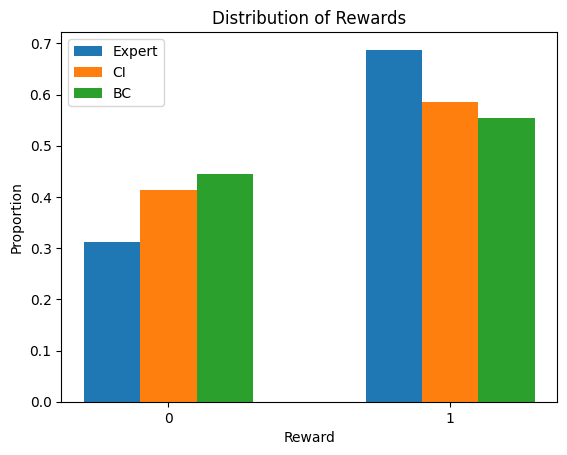

In [33]:
x = np.arange(2)
width = 0.2

# Create the plot
fig, ax = plt.subplots()
ax.bar(x - width, expert_dist, width, label='Expert')
ax.bar(x, ci_dist, width, label='CI')
ax.bar(x + width, bc_dist, width, label='BC')

# Add labels, title, and legend
ax.set_xlabel('Reward')
ax.set_ylabel('Proportion')
ax.set_title('Distribution of Rewards')
ax.set_xticks(x)
ax.legend()

# Show the plot
plt.show()

In [ ]:
runs = 10
episodes = 128

means_expert = []
means_ci = []
means_bc = []

for seed in range(runs):
    records = collect_expert_trajectories(pch, num_episodes=128, seed=seed)
    
    expert_rewards = [r['reward'] for r in records]
    means_expert.append(np.mean(expert_rewards))

    # build & train the CI GAN on this seed’s data
    dataset_ci = ExpertDataset(records, cond_vars=['z'], action_var='action')
    loader_ci  = torch.utils.data.DataLoader(dataset_ci, batch_size=64, shuffle=True)
    gen_ci = ConditionalGenerator(cond_dim=1, num_actions=pch.action_space.n, hidden_dim=32)
    disc_ci= Discriminator(cond_dim=1, num_actions=pch.action_space.n, hidden_dim=32)
    trained_ci = train_gan(gen_ci, disc_ci, loader_ci, epochs=60)
    policy_ci_fn = lambda obs: GANPolicy(trained_ci)([obs['z']])

    # same for the BC GAN
    dataset_bc = ExpertDataset(records, cond_vars=['z','w'], action_var='action')
    loader_bc  = torch.utils.data.DataLoader(dataset_bc, batch_size=64, shuffle=True)
    gen_bc = ConditionalGenerator(cond_dim=2, num_actions=pch.action_space.n, hidden_dim=32)
    disc_bc= Discriminator(cond_dim=2, num_actions=pch.action_space.n, hidden_dim=32)
    trained_bc = train_gan(gen_bc, disc_bc, loader_bc, epochs=60)
    policy_bc_fn = lambda obs: GANPolicy(trained_bc)([obs['z'], obs['w']])

    # roll out each freshly‑trained policy
    ys_ci = rollout_policy(pch, policy_ci_fn,  num_episodes=episodes)
    ys_bc = rollout_policy(pch, policy_bc_fn,  num_episodes=episodes)

    means_ci.append(np.mean(ys_ci))
    means_bc.append(np.mean(ys_bc))

# plot E[Y]
plt.hist(means_ci, bins=20, alpha=0.6, label='CI')
plt.hist(means_bc, bins=20, alpha=0.6, label='BC')
plt.axvline(np.mean(means_expert), color='k', linestyle='--', label='Expert mean')
plt.legend()
plt.xlabel('E[Y]')
plt.ylabel('Number of runs')
plt.show()